In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [9]:
def categorize_pval(df, col= '-log10(pval)'):
    new_df = df.copy()
    conditions  = [ new_df[col] < 1, 
                   (new_df[col] >= 1) & (new_df[col]< 2), 
                   (new_df[col] >= 2) & (new_df[col]< 3), 
                   (new_df[col] >= 3) & (new_df[col]< 4),
                  new_df[col] >= 4]
    choices     = [ "< 1", '[1,2)', '[2,3)', '[3,4)', '>= 4' ]
    new_df["-log10(pval) bins"] = np.select(conditions, choices, default=np.nan)
    return new_df
def chip_graph(df, title, save = False):
    choices     = [ "< 1", '[1,2)', '[2,3)', '[3,4)', '>= 4' ]
    plt.figure(figsize=(7, 5))
    ax = sns.barplot(data=df, x='-log10(pval) bins', 
                y = 'counts', hue="ATACseq", order = choices)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),title='ATACseq Cell Line', fontsize=20)
    plt.setp(ax.get_legend().get_title(), fontsize='20')

    ax.set_title(title, fontsize=25)

    plt.xlabel('-log10(p-value) Bins',fontsize=20)
    sns.despine()
    plt.ylabel('Counts',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
#     if save == True:
#         #atac_graph_out = '/Users/fzheng/Library/CloudStorage/GoogleDrive-fzheng@broadinstitute.org/Shared drives/GPP Cloud /R&D/People/Fengyi/rule_set/crispri/figure/2023/CRISPRi/ATACseq/'
#         plt.savefig(atac_graph_out + title + '.png',
#                    dpi = 1000, bbox_inches='tight')

In [10]:
out_path = '../../Data/ATACseq/Pval/'
results_df = pd.read_csv(out_path+'ATAC_Pval.csv')
results_df['DataSetID'] = results_df[['DataSet', 'Domain', 'condition']].agg("_".join, axis=1)

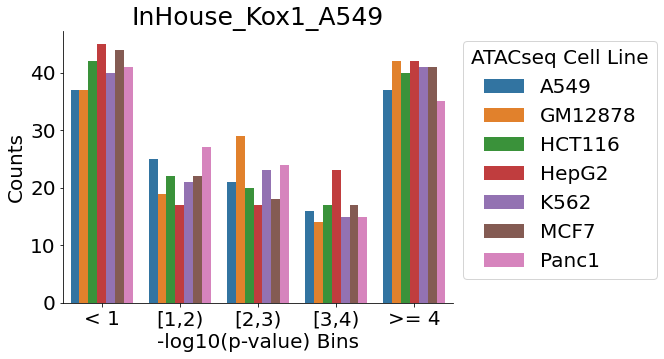

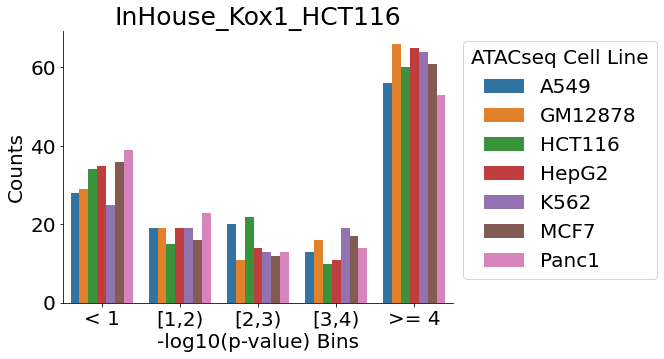

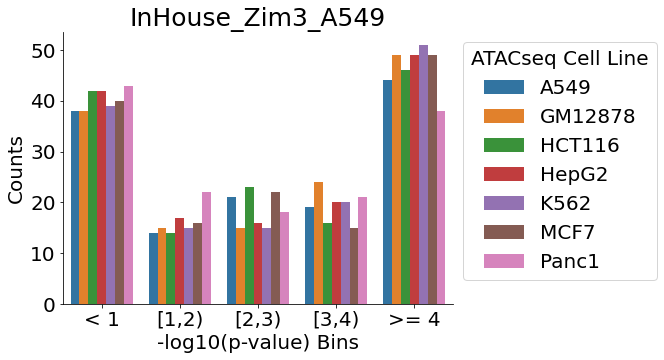

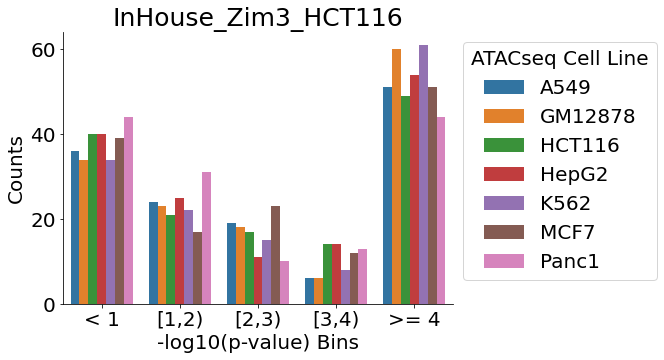

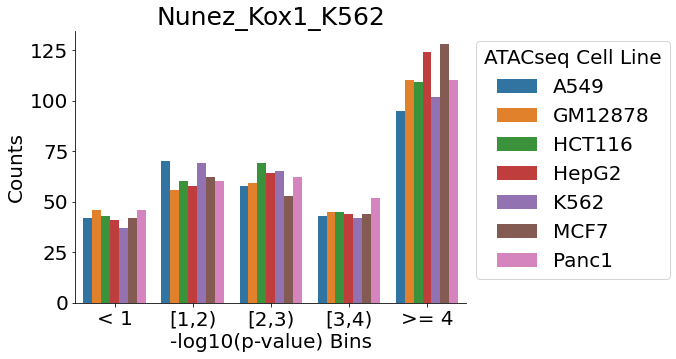

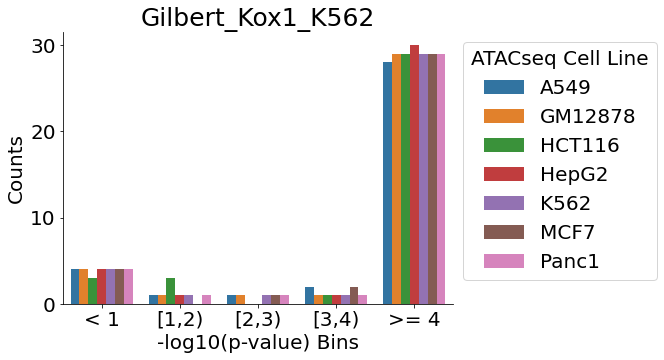

In [11]:
allDataCount = pd.DataFrame()
for dataset in results_df.DataSetID.unique():
    select_pval = results_df[results_df.DataSetID == dataset].copy()
    #select_pval = select_pval.groupby('gene').filter(lambda g: len(g) == 7)
    select_pval['-log10(pval)'] = -np.log10(select_pval['pval'])
    select_pval = categorize_pval(select_pval)
    select_count = pd.DataFrame(select_pval.groupby(['-log10(pval) bins', 'ATACseq']).size().reset_index(name='counts'))
    select_count['DataSetID'] = dataset
    allDataCount = pd.concat([allDataCount, select_count])
    chip_graph(select_count, dataset)

In [12]:
allDataCount

,-log10(pval) bins,ATACseq,counts,DataSetID
0,< 1,A549,37,InHouse_Kox1_A549
1,< 1,GM12878,37,InHouse_Kox1_A549
2,< 1,HCT116,42,InHouse_Kox1_A549
3,< 1,HepG2,45,InHouse_Kox1_A549
4,< 1,K562,40,InHouse_Kox1_A549
...,...,...,...,...
27,"[3,4)",HCT116,1,Gilbert_Kox1_K562
28,"[3,4)",HepG2,1,Gilbert_Kox1_K562
29,"[3,4)",K562,1,Gilbert_Kox1_K562
30,"[3,4)",MCF7,2,Gilbert_Kox1_K562


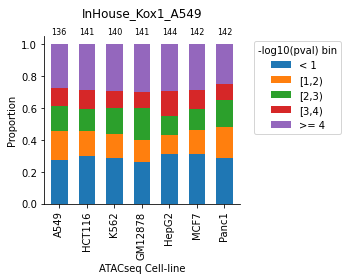

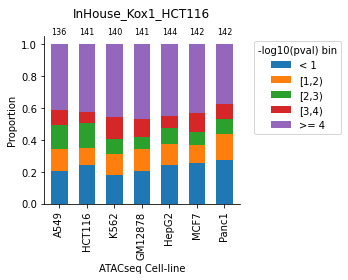

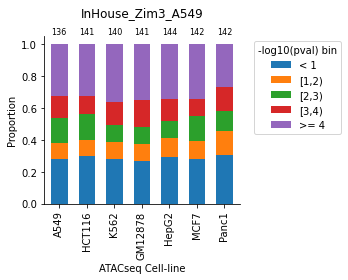

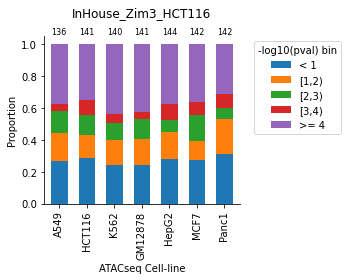

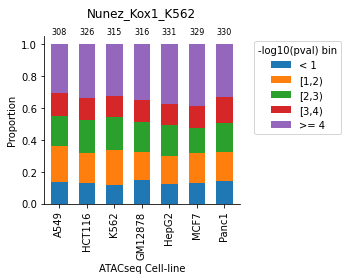

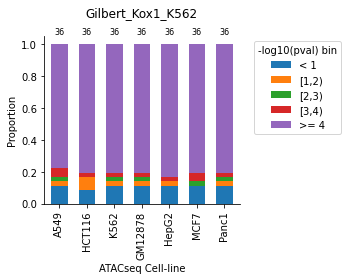

In [13]:
import matplotlib.pyplot as plt
graph_pathout = '../../Figure/Figure 3/Individual Figures/'

for selectData in allDataCount['DataSetID'].unique():
    select_count = allDataCount[allDataCount.DataSetID == selectData].copy()

    grouped_df = select_count.groupby(['-log10(pval) bins', 'ATACseq'])['counts'].sum().unstack().fillna(0)
    grouped_df = grouped_df[['A549',  'HCT116', 'K562', 'GM12878','HepG2', 'MCF7', 'Panc1']]
    # Calculate percentages
    grouped_df_percentage = grouped_df.transpose().divide(grouped_df.sum(axis=0), axis=0)
    grouped_df_percentage = grouped_df_percentage[['< 1','[1,2)',  '[2,3)','[3,4)','>= 4']]
    # Plotting
    fig, ax = plt.subplots(figsize=(5, 4))

    grouped_df_percentage.plot(kind='bar', stacked=True, ax=ax, width=0.6)

    
     # Add percentages to the bars and the total count
    for i in range(grouped_df_percentage.shape[0]):
        total = 0
        totalCount = grouped_df.iloc[:, i].sum()  # Calculate the total count for each stack
        # Add total count text on top of each stack
        ax.text(i, 1.05, f'{int(totalCount)}', ha='center', va='bottom', fontsize=8, fontweight='light', color='black')

    plt.ylabel('Proportion')
    plt.xlabel('ATACseq Cell-line')
    plt.title(selectData,pad =20)
    plt.legend(title='-log10(pval) bin', bbox_to_anchor=(1.05, 1), loc='upper left')
    sns.despine()
    plt.tight_layout()
    plt.savefig(graph_pathout + selectData+"_ATAC_v2.pdf", dpi=300, bbox_inches='tight')
    plt.show()